# Multilevel Elasticities for a Single SKU - Part II.

In this notebook we go deeper into the last covariance model presented in the previous blog post [Multilevel Elasticities for a Single SKU](https://juanitorduz.github.io/multilevel_elasticities_single_sku/). In particular we describe how to generate posterior predictive samples from an unseen region by the model. We strongly recommend reading the previous blog post before reading this one as we will skip the EDA and baseline model comparison parts.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "multilevel_elasticities_single_sku"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We begin by reading the data from the previous notebook.

In [3]:
market_df = pd.read_csv("../data/multilevel_elasticities_single_sku_data.csv")

market_df.head()

item_id     price  quantities  time_step  store_id region_store_id  \
0        0  1.335446    6.170862         16         0         r-0_s-0   
1        0  1.702792    3.715124         15         0         r-0_s-0   
2        0  1.699778    3.290962         14         0         r-0_s-0   
3        0  1.335844    5.702928         13         0         r-0_s-0   
4        0  1.517213    4.264949         12         0         r-0_s-0   

   region_id  median_income  log_price  log_quantities  
0          0       5.873343   0.289265        1.819839  
1          0       5.873343   0.532269        1.312412  
2          0       5.873343   0.530498        1.191180  
3          0       5.873343   0.289563        1.740980  
4          0       5.873343   0.416875        1.450430

Recall we want to estimate the SKU elasticities at region level using a log-log model of price and demand. We have $9$ regions in the data set:

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Log Prices vs Log Quantities by Region')

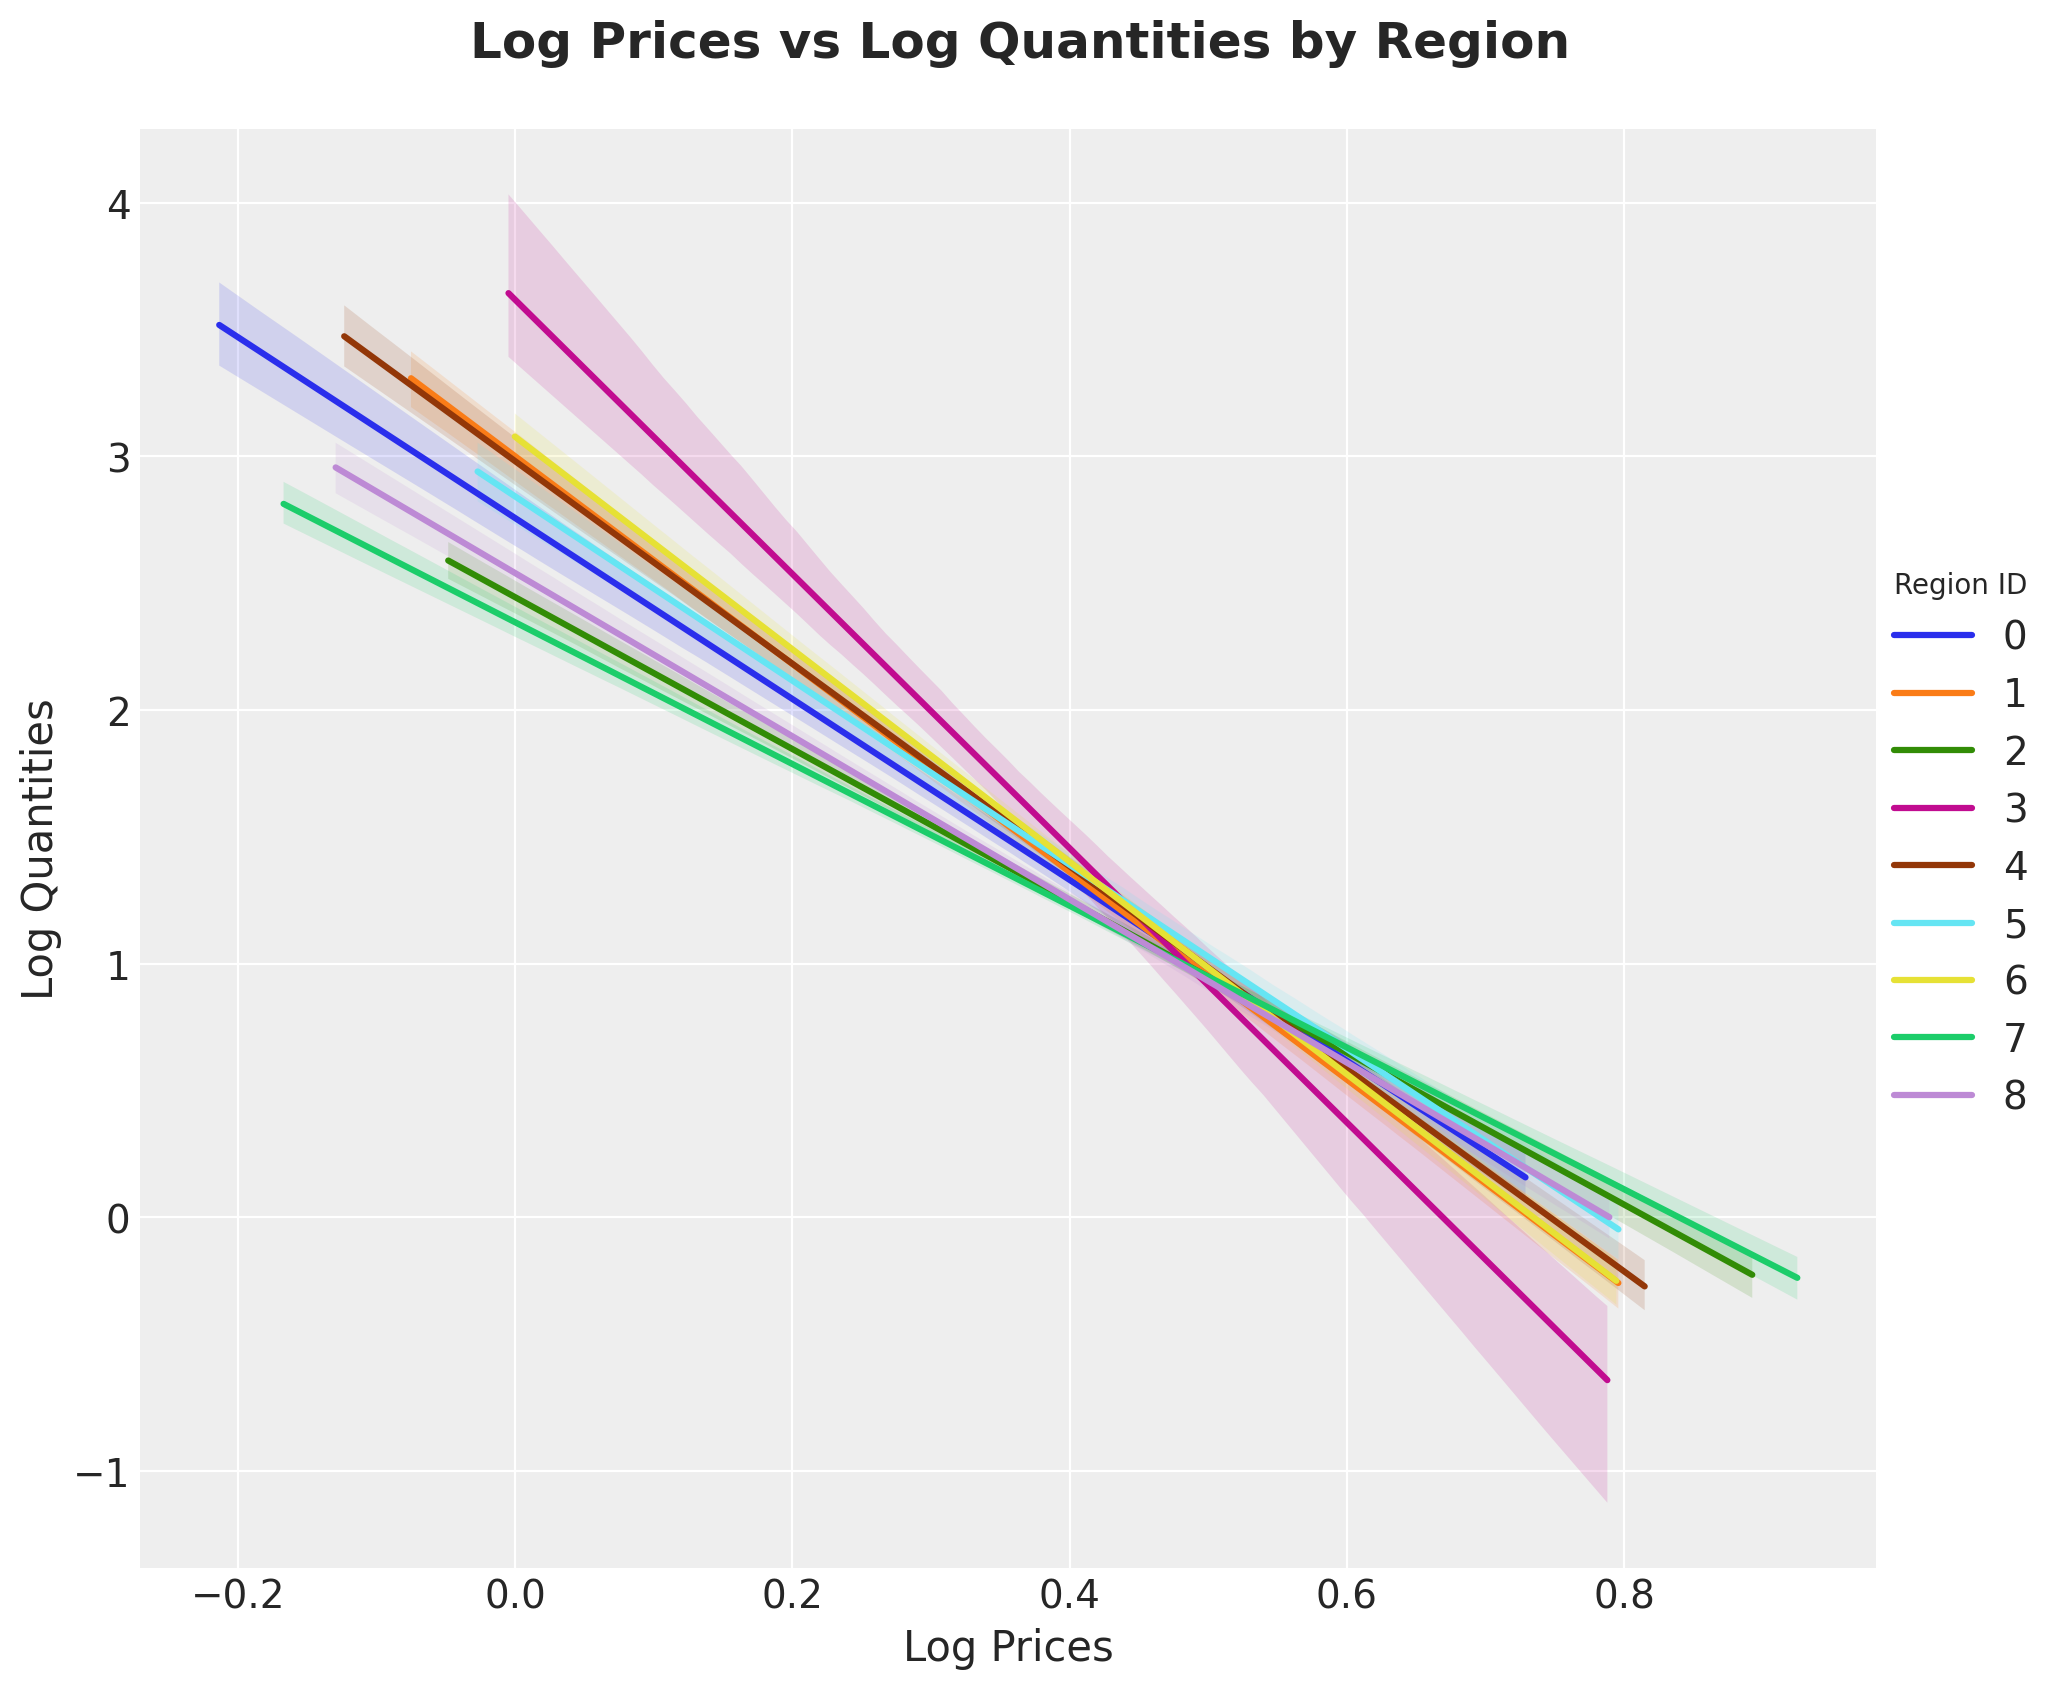

In [4]:
g = sns.lmplot(
    data=market_df,
    x="log_price",
    y="log_quantities",
    hue="region_id",
    height=8,
    aspect=1.2,
    scatter=False,
)
g.set_axis_labels(x_var="Log Prices", y_var="Log Quantities")
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle(
    "Log Prices vs Log Quantities by Region", y=1.05, fontsize=18, fontweight="bold"
)

In this context, the elasticities are nothing else than the slopes of the lines above. In the previous notebook, we saw that these slopes can be explained by an additional variable: `median_income`. 

An important point in the plot above is that the **intercepts and slopes are correlated** 💡. Note how higher slopes correspond the lower intercepts. This key observation motivated modeling the covariance matrix of the intercepts and slopes. We will revisit the model specification below.

## Prepare Data

In contrast to the previous notebook, we will not fit the model for all regions but only for $8$ of them. We will use the last region as a holdout set to generate posterior predictive samples. This is to illustrate how one can use hierarchical models to generate prediction (and parameter inference like elasticities) for unseen categories, in this case regions.

In [5]:
# We do not include region 8 in the model
region_id_out = 8

market_red_df = market_df.query("region_id != @region_id_out")
market_out_df = market_df.query("region_id == @region_id_out")

We use the suffix `_red` (reduced) to denote the quantities (model, plots, ..., etc) fitted just with $8$ regions.

In [6]:
obs_red = market_red_df.index.to_numpy()
price_red = market_red_df["price"].to_numpy()
log_price_red = market_red_df["log_price"].to_numpy()
quantities_red = market_red_df["quantities"].to_numpy()
log_quantities_red = market_red_df["log_quantities"].to_numpy()
median_income_idx_red, median_income_red = market_red_df["median_income"].factorize(
    sort=True
)
region_idx_red, region_red = market_red_df["region_id"].factorize(sort=True)

Without the suffix we refer to the quantities fitted with all $9$ regions.

In [7]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = market_df["log_price"].to_numpy()
quantities = market_df["quantities"].to_numpy()
log_quantities = market_df["log_quantities"].to_numpy()
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)

## Specify Model

The model specification is the same as in the previous notebook. The only change is that we use data containers and mutable coordinates to make sure we can generate posterior predictive samples for the holdout region. The strategy is to explicitly model the covariance matrix of the intercept and slopes using the [`pm.LKJCholeskyCov`](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.LKJCholeskyCov.html) distribution as explained in the great blog post [Hierarchical modeling with the LKJ prior in PyMC](https://tomicapretto.github.io/posts/2022-06-12_lkj-prior/) by [Tomi Capretto](https://tomicapretto.github.io/).

In [8]:
coords = {
    "effect": ["intercept", "slope"],
}

with pm.Model(coords=coords) as model_cov_red:
    # --- Data Containers ---

    model_cov_red.add_coord(name="region", values=region_red, mutable=True)
    model_cov_red.add_coord(name="obs", values=obs_red, mutable=True)

    region_idx_data = pm.Data(
        name="region_idx_data", value=region_idx_red, mutable=True, dims="obs"
    )
    median_income_data = pm.Data(
        name="median_income_data",
        value=median_income_red.to_numpy(),
        mutable=True,
        dims="region",
    )
    log_price_data = pm.Data(
        name="log_price_data", value=log_price_red, mutable=True, dims="obs"
    )
    log_quantities_data = pm.Data(
        name="log_quantities_data", value=log_quantities_red, mutable=True, dims="obs"
    )

    # --- Priors ---
    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)

    sd_dist = pm.HalfNormal.dist(sigma=0.02, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    z_slopes = pm.Normal(name="z_slopes", mu=0, sigma=1, dims=("effect", "region"))
    slopes = pm.Deterministic(
        name="slopes", var=pt.dot(chol, z_slopes).T, dims=("region", "effect")
    )

    # --- Parametrization ---
    alpha_j_slope = pm.Deterministic(
        name="alpha_j_slope", var=slopes[:, 0], dims="region"
    )

    beta_j_slope = pm.Deterministic(
        name="beta_j_slope", var=slopes[:, 1], dims="region"
    )

    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_intercept + alpha_j_slope * median_income_data,
        dims="region",
    )

    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_intercept + beta_j_slope * median_income_data,
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx_data], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx_data], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price_data, dims="obs")

    # --- Likelihood ---
    pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=log_quantities_data, dims="obs"
    )

pm.model_to_graphviz(model=model_cov_red)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Fit Model

Now we fit the model and generate posterior predictive samples.

In [9]:
with model_cov_red:
    idata_cov_red = pm.sample(
        target_accept=0.9,
        draws=6_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_cov_red = pm.sample_posterior_predictive(
        trace=idata_cov_red, random_seed=rng
    )

Compiling...
Compilation time = 0:00:03.920840
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time = 0:00:37.414419
Transforming variables...
Transformation time = 0:00:03.364269
Sampling: [likelihood]


We can now take a look at the trace:

Text(0.5, 0.98, 'Covariance Multilevel Model (Red) - Trace')

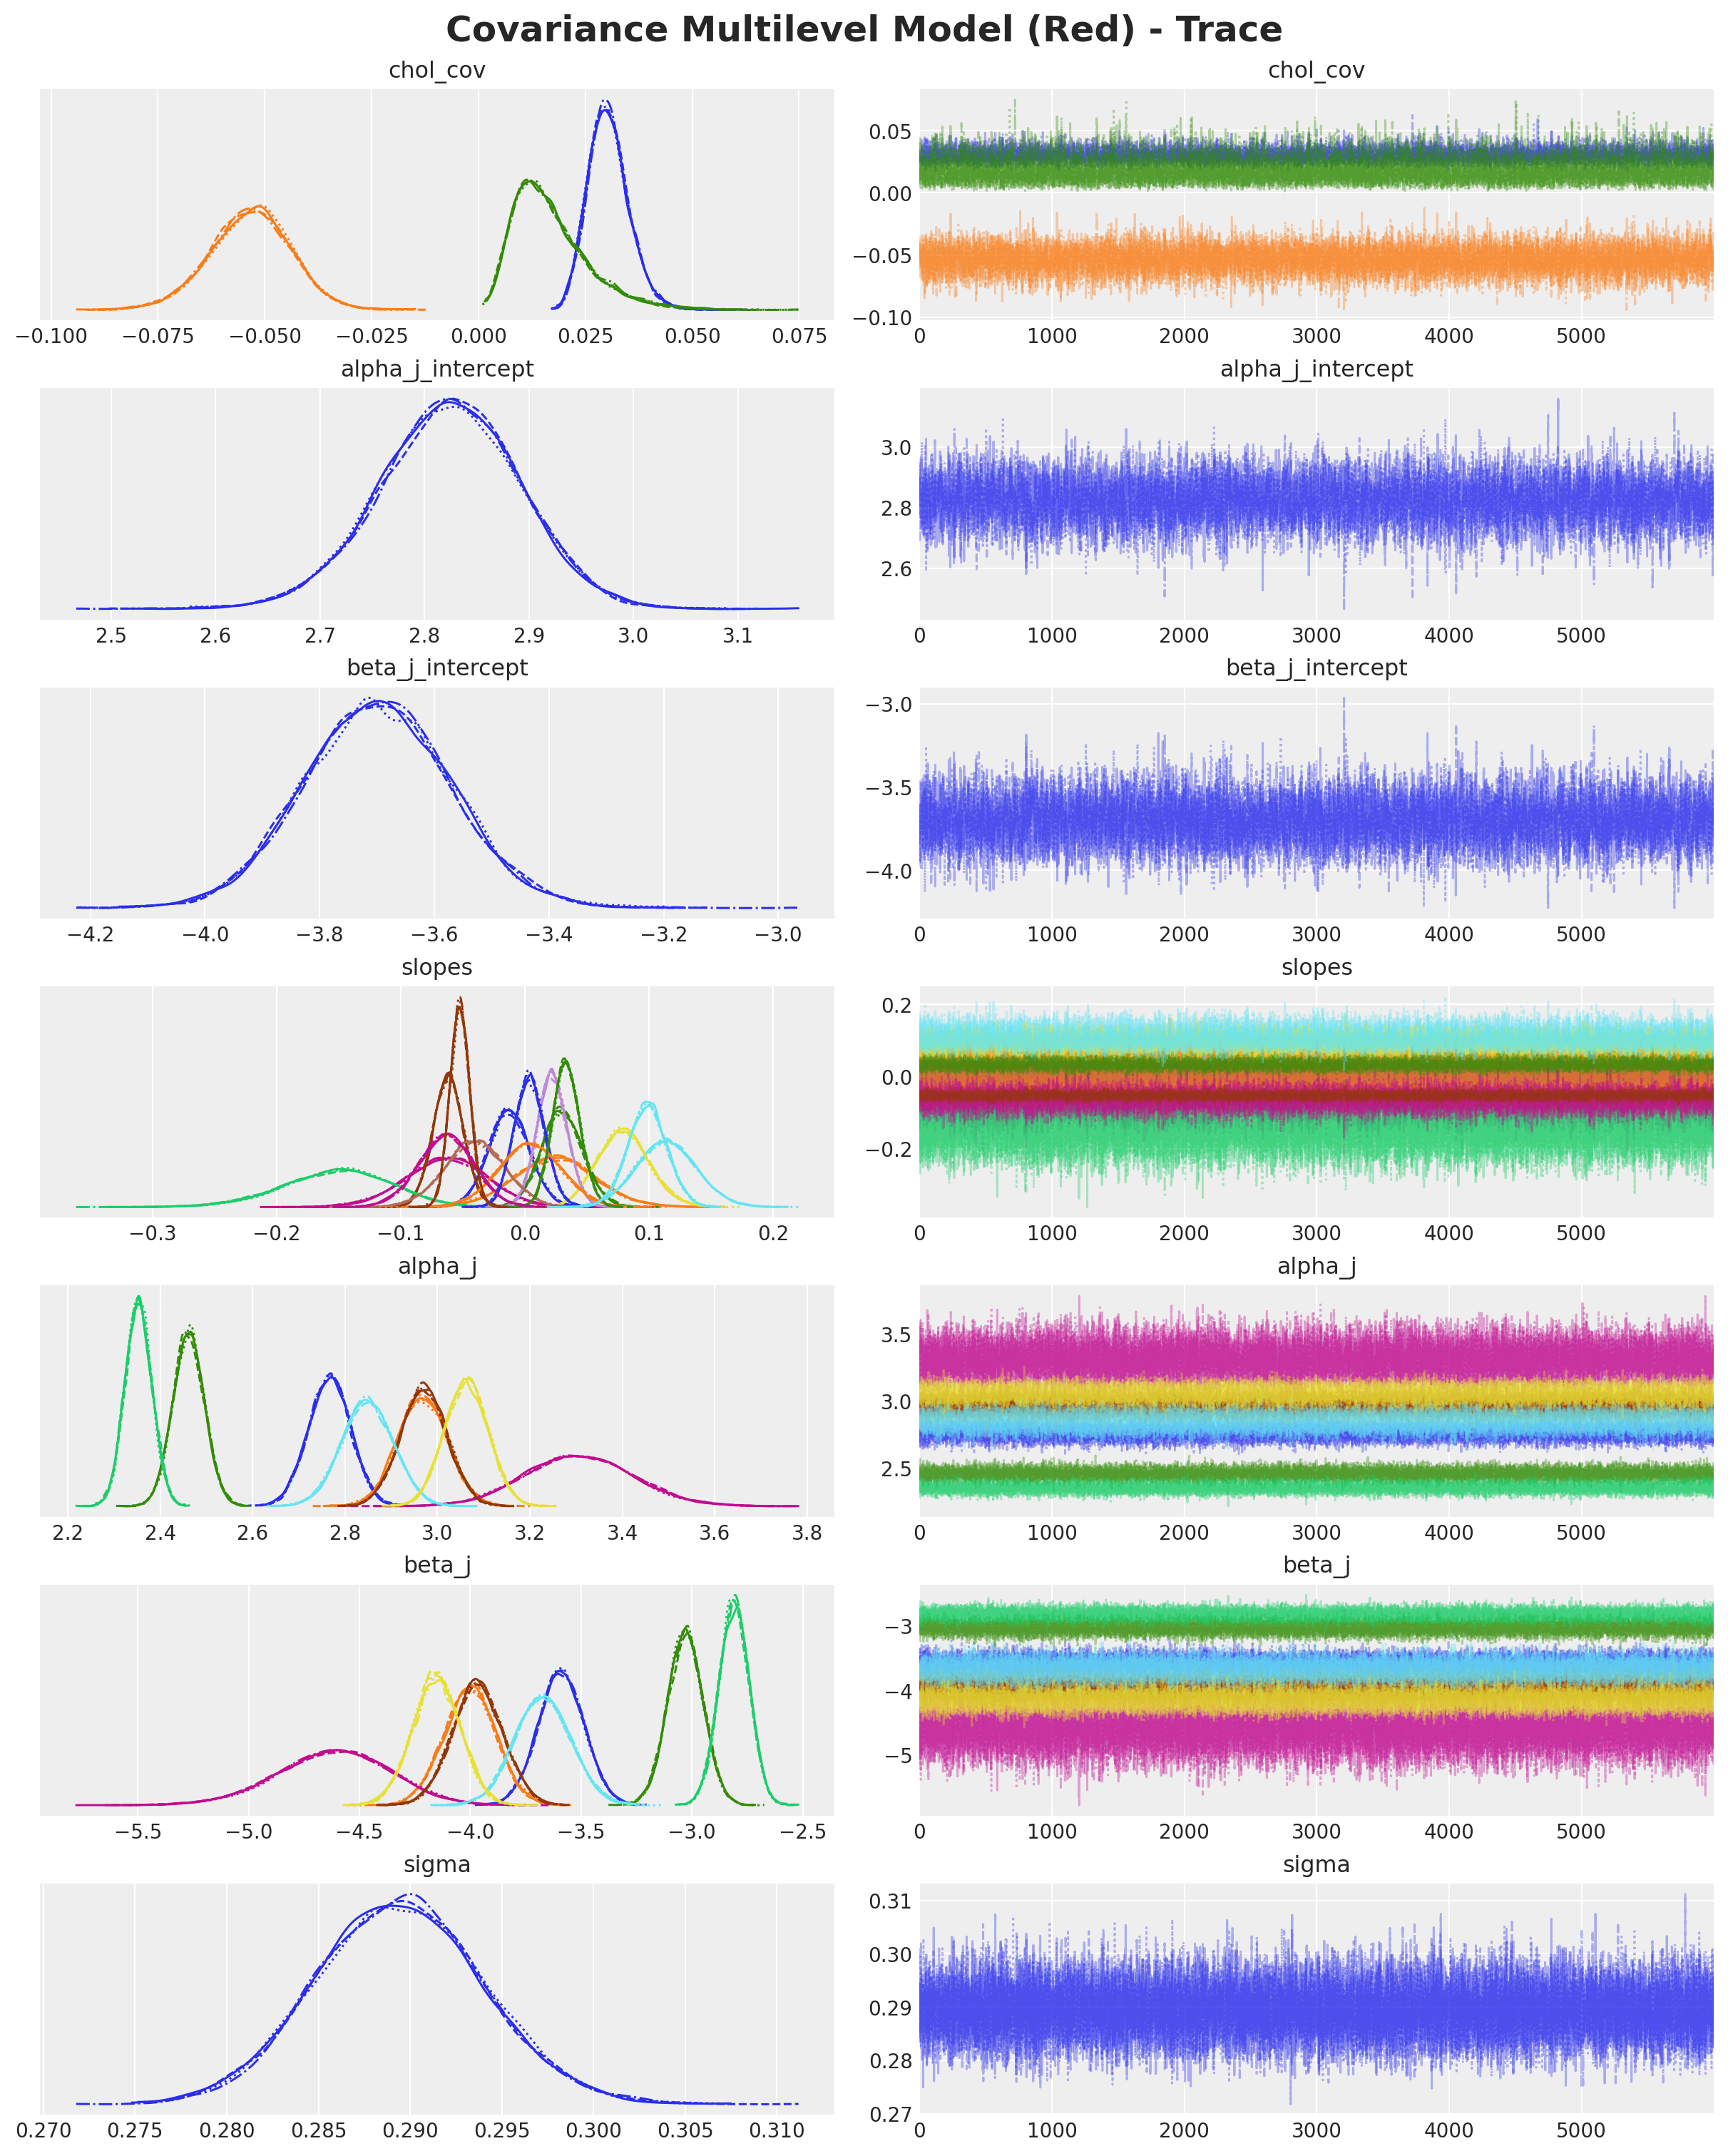

In [10]:
var_names = [
    "chol_cov",
    "alpha_j_intercept",
    "beta_j_intercept",
    "slopes",
    "alpha_j",
    "beta_j",
    "sigma",
]


axes = az.plot_trace(
    data=idata_cov_red,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Covariance Multilevel Model (Reduced) - Trace", fontsize=18, fontweight="bold"
)

## Covariance Deep Dive

We now look deeper into the covariance matrix of the intercepts and slopes. Specifically, we take a look into the correlation component:

In [11]:
chol_cov_corr_posterior_red = idata_cov_red["posterior"]["chol_cov_corr"].sel(
    chol_cov_corr_dim_0=0, chol_cov_corr_dim_1=1
)

Let's look into the posterior distribution:

[Text(0.5, 1.0, 'Correlation Posterior Distribution'),
 Text(0.5, 0, 'correlation')]

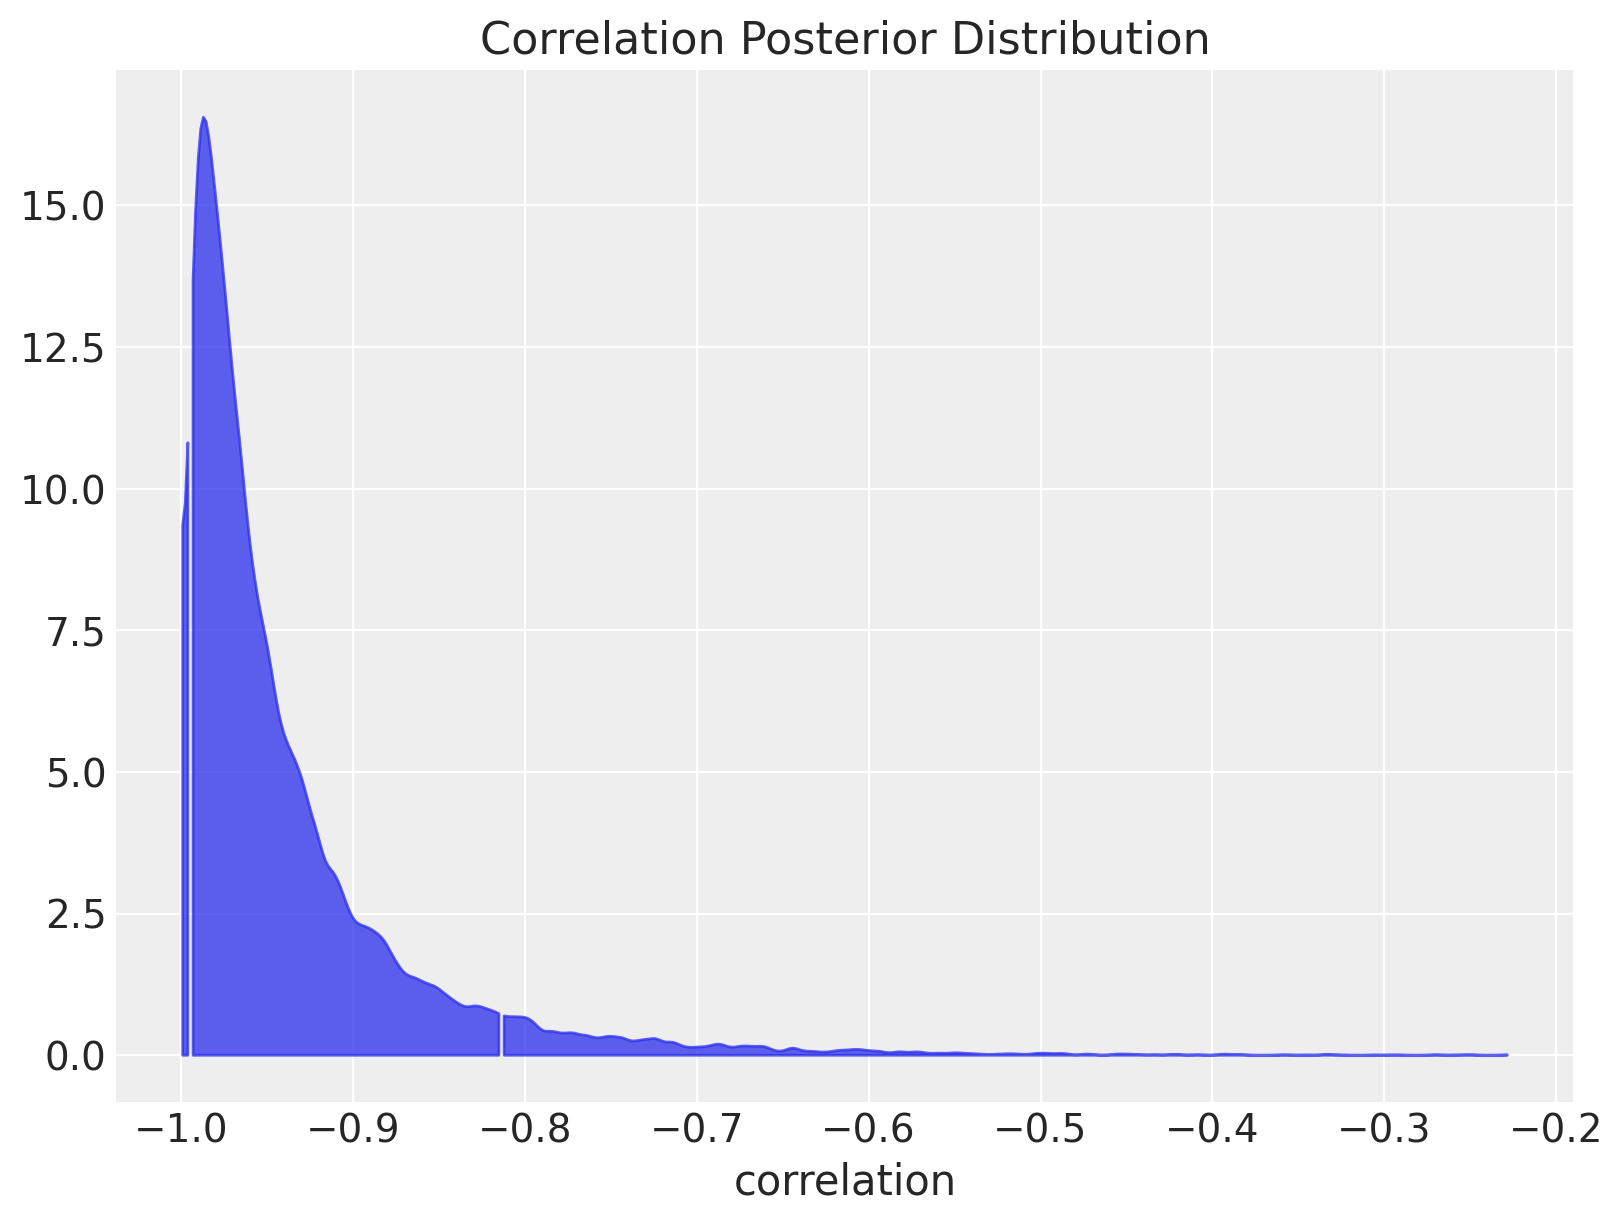

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(values=chol_cov_corr_posterior_red, quantiles=[0.06, 0.94], ax=ax)
ax.set(title="Correlation Posterior Distribution", xlabel="correlation")

The plot above shows that the correlation is negative anv quite close to $-1$ as expected. 

We can now plot the intercepts and slopes samples per region.

[Text(0.5, 1.0, 'Intercepts & Slopes Posterior Samples'),
 Text(0.5, 0, 'intercepts ($\\alpha_{j}$)'),
 Text(0, 0.5, 'slopes ($\\beta_{}$)')]

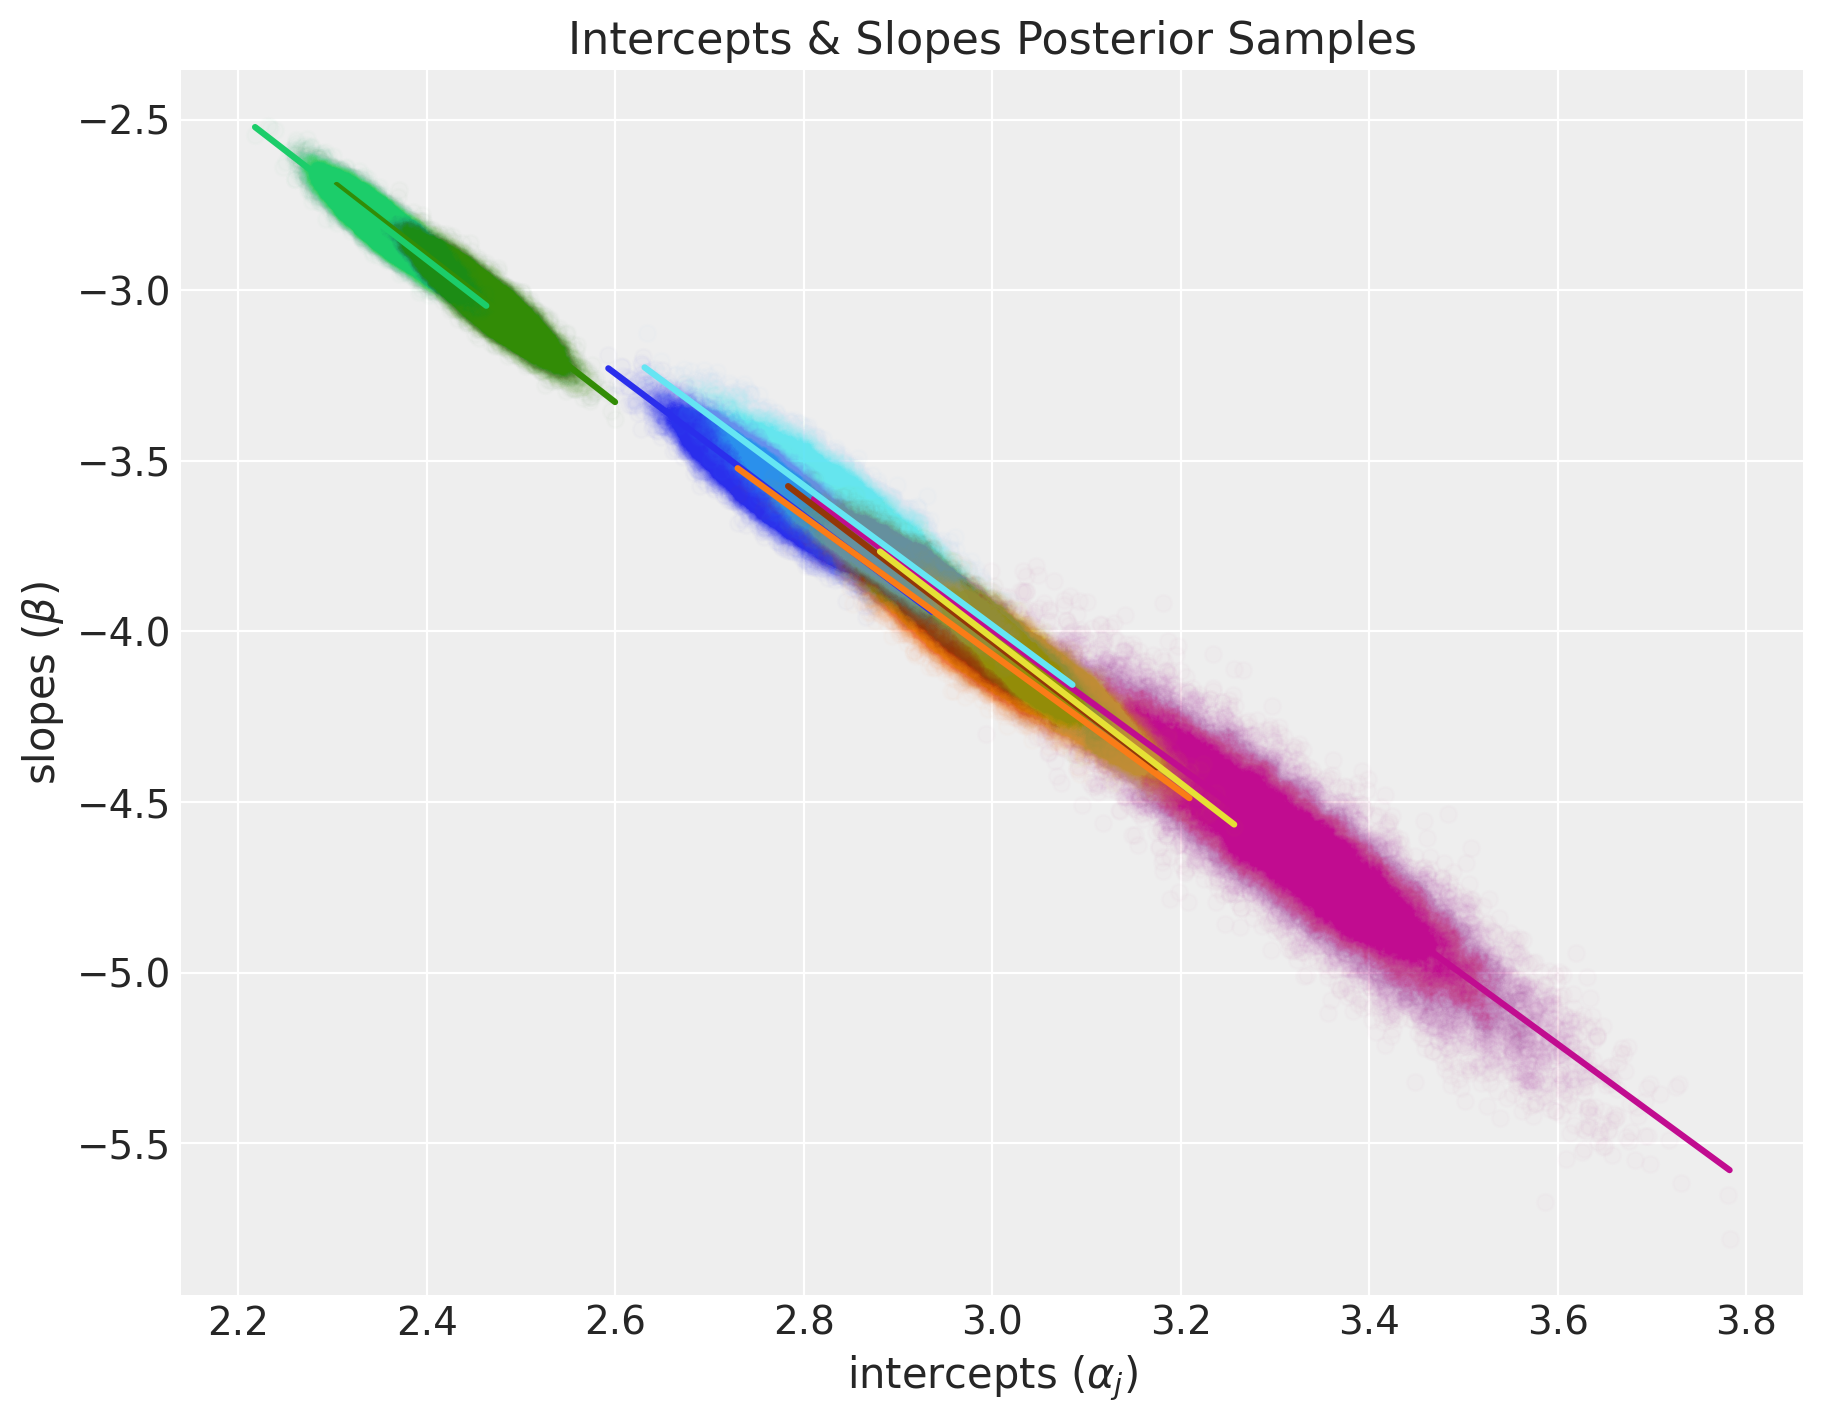

In [13]:
alpha_j_samples_red = az.extract(data=idata_cov_red, var_names=["alpha_j"])
beta_j_samples_red = az.extract(data=idata_cov_red, var_names=["beta_j"])


fig, ax = plt.subplots(figsize=(9, 7))

for r in region_red:
    sns.regplot(
        x=alpha_j_samples_red.sel(region=r),
        y=beta_j_samples_red.sel(region=r),
        scatter_kws={"alpha": 0.01},
        ax=ax,
    )

ax.set(
    title="Intercepts & Slopes Posterior Samples",
    xlabel=r"intercepts ($\alpha_{j}$)",
    ylabel=r"slopes ($\beta_{}$)",
)

We indeed see the negative correlation between regions

We now take samples of the generated lines in the log-log space:

[Text(0.5, 1.0, 'Posterior Predictive'),
 Text(0.5, 0, 'Log Prices'),
 Text(0, 0.5, 'Log Quantities'),
 (-0.2, 1.0),
 (-1.0, 4.0)]

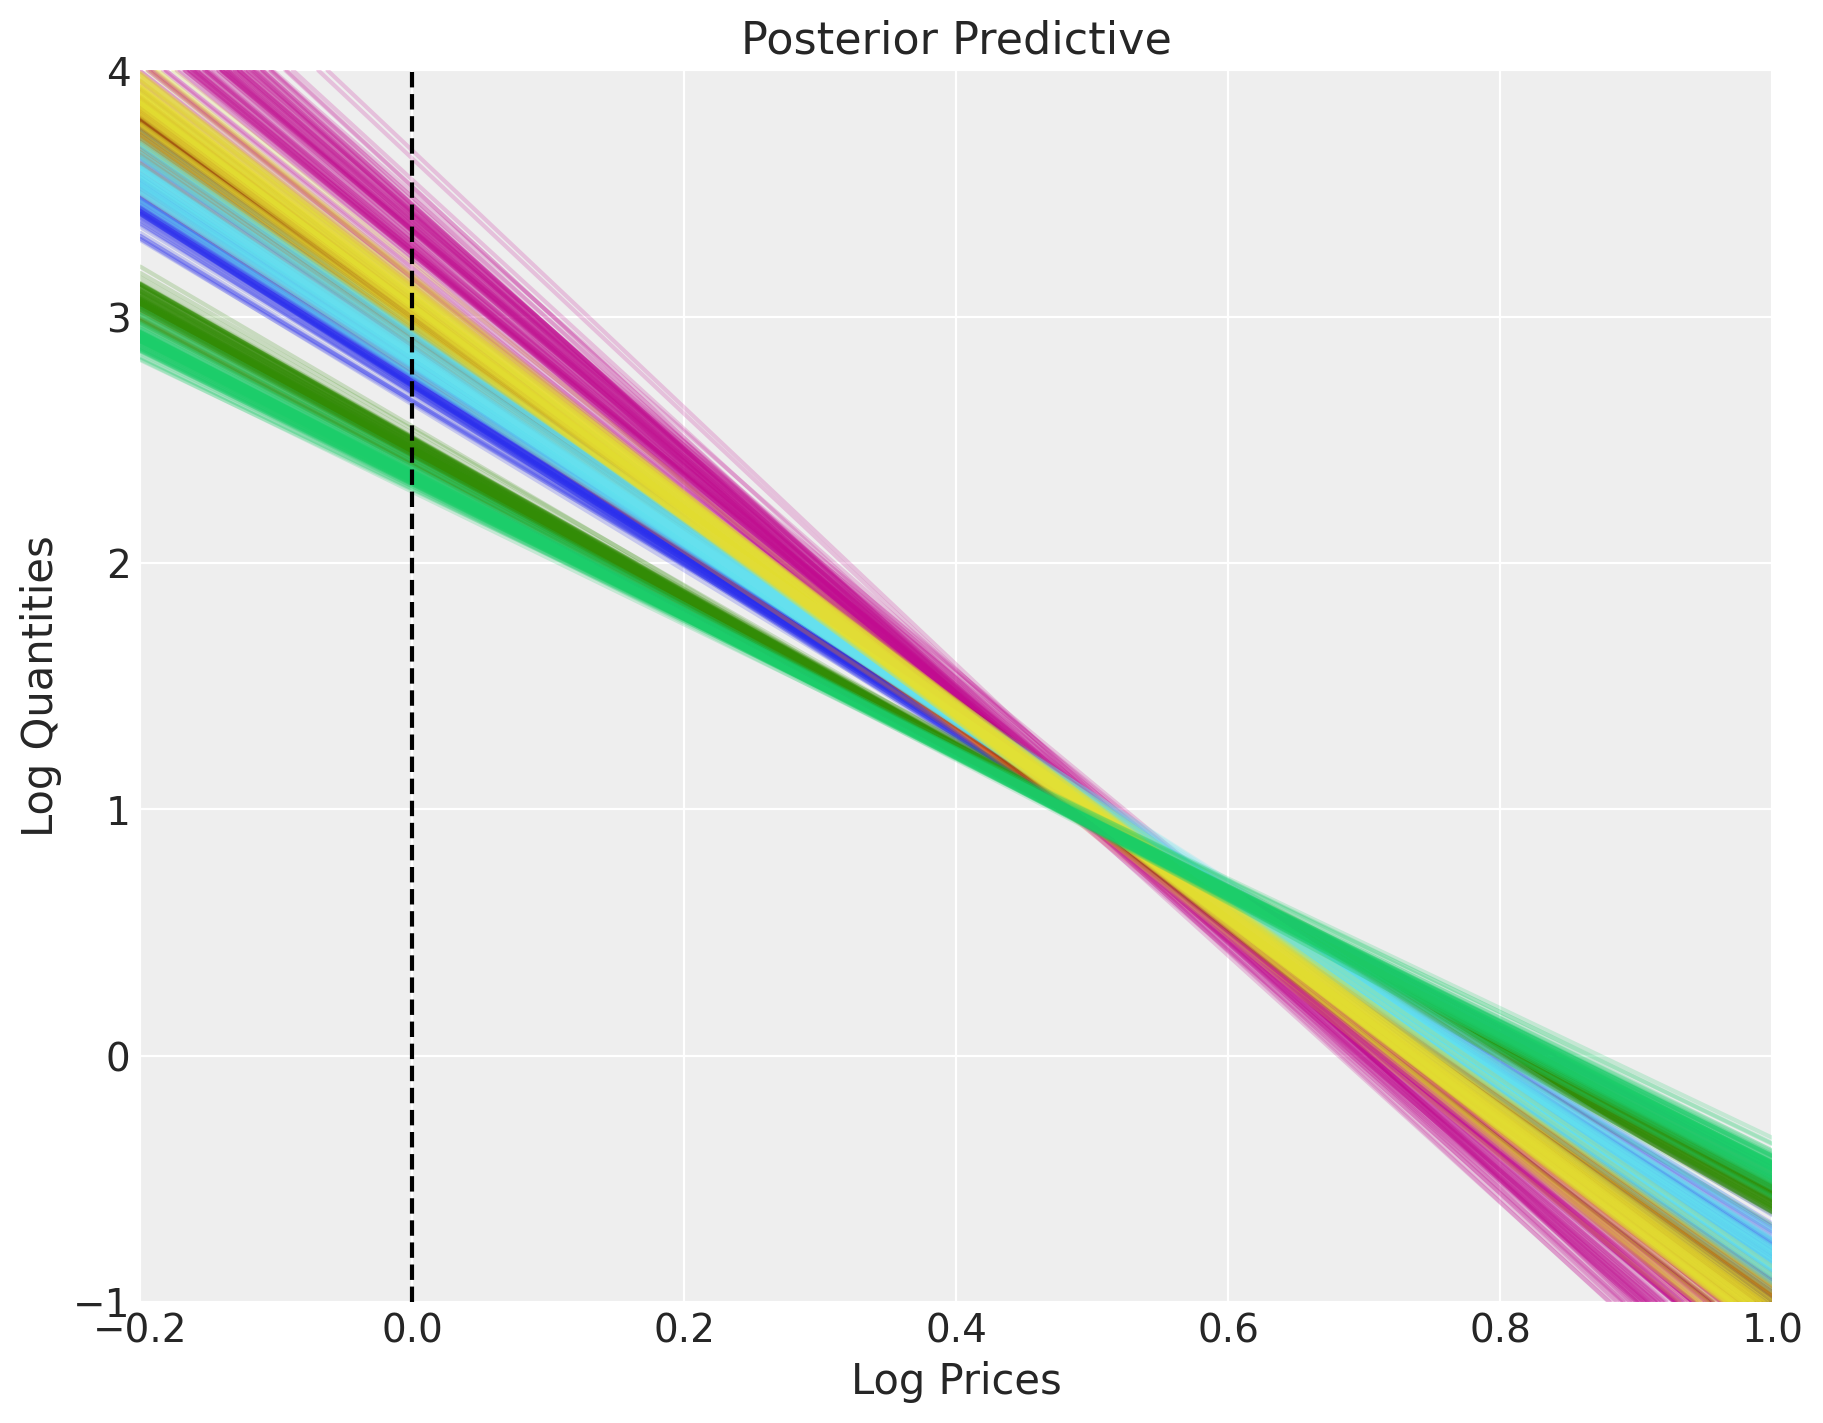

In [14]:
fig, ax = plt.subplots(figsize=(9, 7))

n_samples = 100

for r in region_red:
    for a, b in zip(
        alpha_j_samples_red.sel(region=r)[:n_samples],
        beta_j_samples_red.sel(region=r)[:n_samples],
    ):
        ax.axline(xy1=(0, a), slope=b, color=f"C{r}", alpha=0.2)

ax.axvline(x=0, color="black", linestyle="--")
ax.set(
    title="Posterior Predictive",
    xlabel="Log Prices",
    ylabel="Log Quantities",
    xlim=(-0.2, 1),
    ylim=(-1, 4),
)

This plot looks very similar to the one at the beginning of the notebook. Hence, we see that the posterior predictive samples are able to capture the correlation between intercepts and slopes.

## Posterior Predictive for Holdout Region

We now replace the region coordinates to add the holdout region and generate posterior predictive samples for it.

In [15]:
with model_cov_red:
    pm.set_data(
        new_data={
            "region_idx_data": region_idx,
            "median_income_data": median_income.to_numpy(),
            "log_price_data": log_price,
            "log_quantities_data": log_quantities,
        },
        coords={"region": region, "obs": obs},
    )
    posterior_predictive_cov = pm.sample_posterior_predictive(
        trace=idata_cov_red,
        var_names=["alpha_j", "beta_j", "likelihood"],
        random_seed=rng,
    )

Sampling: [likelihood, z_slopes]


We are interested in looking into the induced intercepts, slopes and elasticities for this new region:

### Intercepts and Slopes

[Text(0.5, 1.0, 'Intercepts & Slopes Posterior Samples (New Region)'),
 Text(0.5, 0, 'intercepts ($\\alpha_{j}$)'),
 Text(0, 0.5, 'slopes ($\\beta_{}$)')]

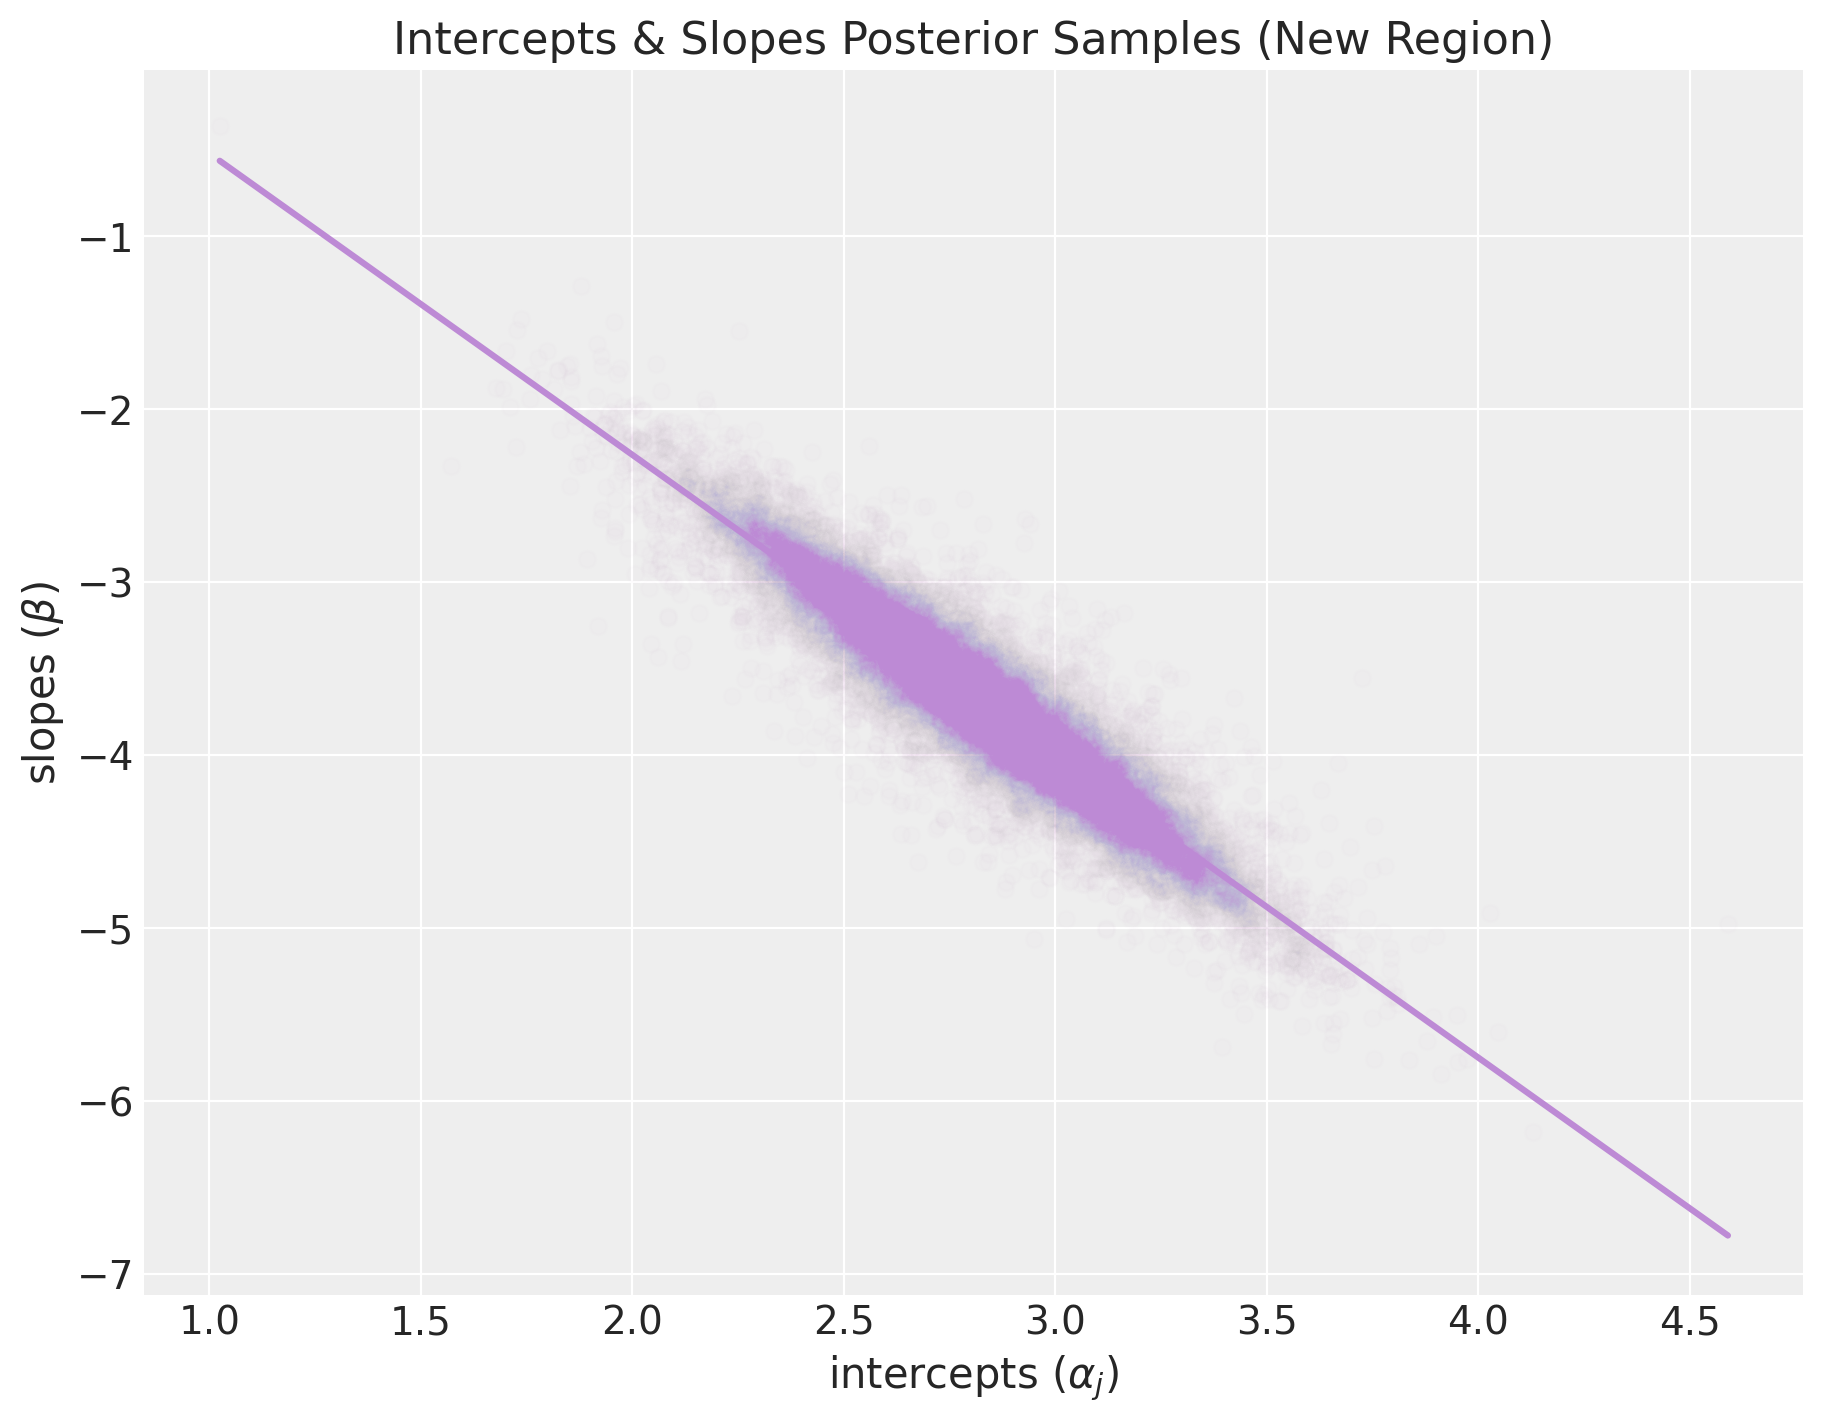

In [17]:
alpha_j_samples = az.extract(
    data=posterior_predictive_cov, group="posterior_predictive", var_names=["alpha_j"]
)
beta_j_samples = az.extract(
    data=posterior_predictive_cov, group="posterior_predictive", var_names=["beta_j"]
)

fig, ax = plt.subplots(figsize=(9, 7))
sns.regplot(
    x=alpha_j_samples.sel(region=region_id_out),
    y=beta_j_samples.sel(region=region_id_out),
    color=f"C{region_id_out}",
    scatter_kws={"alpha": 0.01},
    ax=ax,
)
ax.set(
    title="Intercepts & Slopes Posterior Samples (New Region)",
    xlabel=r"intercepts ($\alpha_{j}$)",
    ylabel=r"slopes ($\beta_{}$)",
)

[Text(0.5, 1.0, 'Posterior Predictive'),
 Text(0.5, 0, 'Log Prices'),
 Text(0, 0.5, 'Log Quantities'),
 (-0.2, 1.0),
 (-1.0, 4.0)]

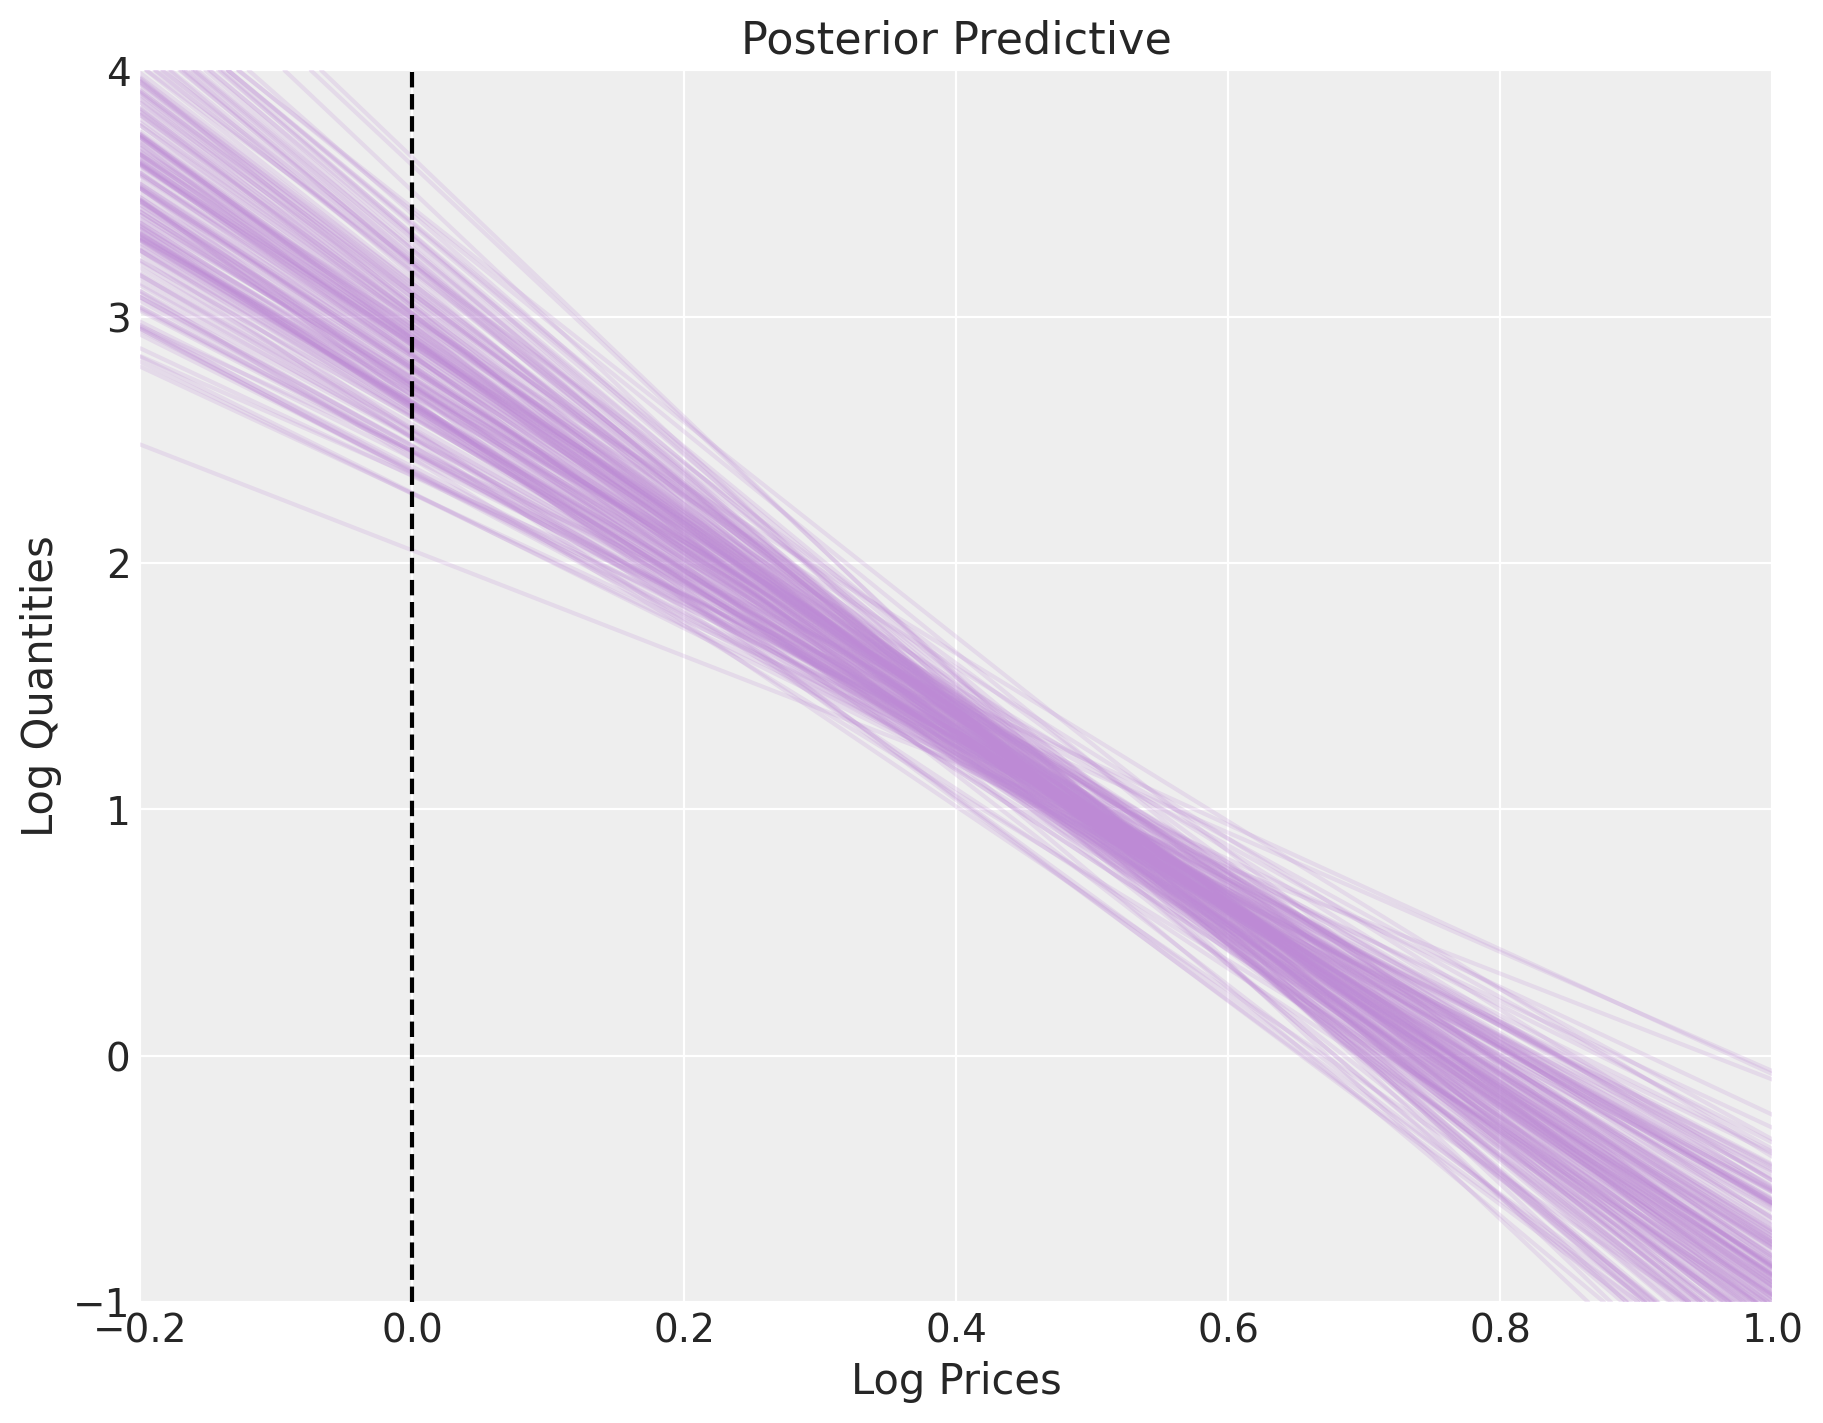

In [18]:
fig, ax = plt.subplots(figsize=(9, 7))

n_samples = 200

for a, b in zip(
    alpha_j_samples.sel(region=region_id_out)[:n_samples],
    beta_j_samples.sel(region=region_id_out)[:n_samples],
):
    ax.axline(xy1=(0, a), slope=b, color=f"C{region_id_out}", alpha=0.2)

ax.axvline(x=0, color="black", linestyle="--")
ax.set(
    title="Posterior Predictive",
    xlabel="Log Prices",
    ylabel="Log Quantities",
    xlim=(-0.2, 1),
    ylim=(-1, 4),
)

We see how the induced lines are in some sense a weighted average of the lines of the other regions. This average is also pushed to the global mean of the intercepts and slopes because of the *shrinkage phenomenon* (see previous notebook). In addition, we have wider credible intervals as expected.

## Elasticities

We can compare the elasticities of the holdout region with the other regions:

Text(0.5, 1.05, 'Covariance Multilevel Model (Reduced)')

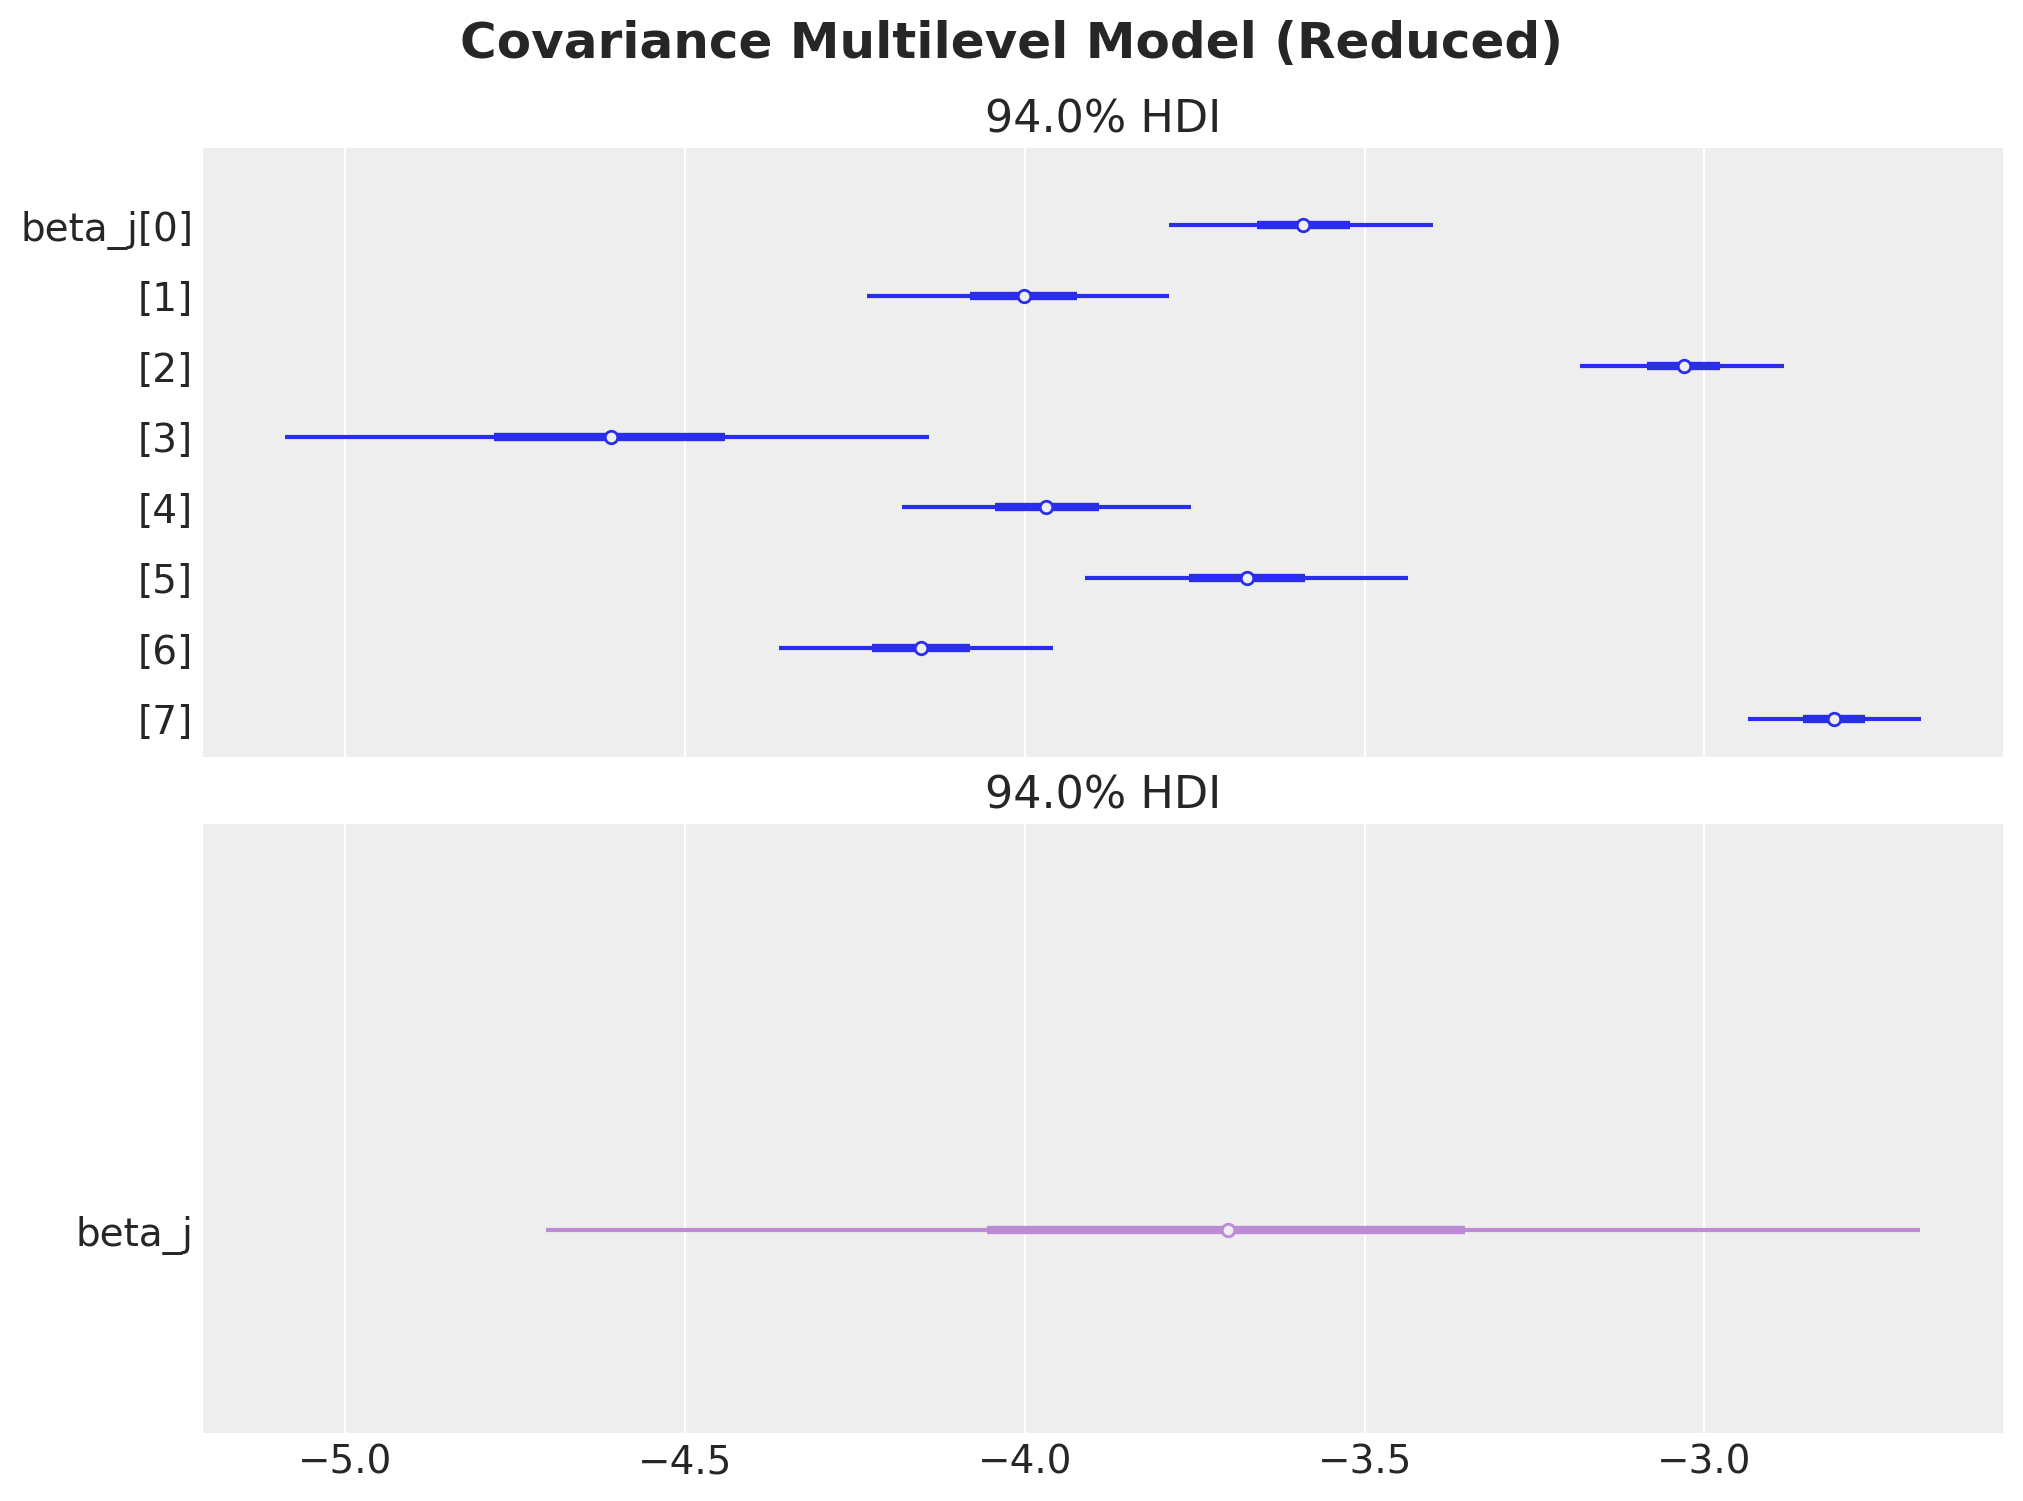

In [34]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=False, layout="constrained"
)

az.plot_forest(
    data=idata_cov_red,
    var_names=["beta_j"],
    combined=True,
    ax=ax[0],
)
az.plot_forest(
    data=posterior_predictive_cov["posterior_predictive"].sel(region=region_id_out),
    var_names=["beta_j"],
    combined=True,
    colors="C8",
    ax=ax[1],
)

fig.suptitle(
    t="Covariance Multilevel Model (Reduced)", fontsize=18, fontweight="bold", y=1.05
)

We also see how the elasticity of ne new region in centered around the global mean. It is also clear that the uncertainty for the new region is higher than for the other regions.

### Posterior Predictive Distribution

Finally we look into the posterior predictive distribution in the original price-quantity scale:

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Prices vs Quantities by Region - Covariance Multilevel Model')

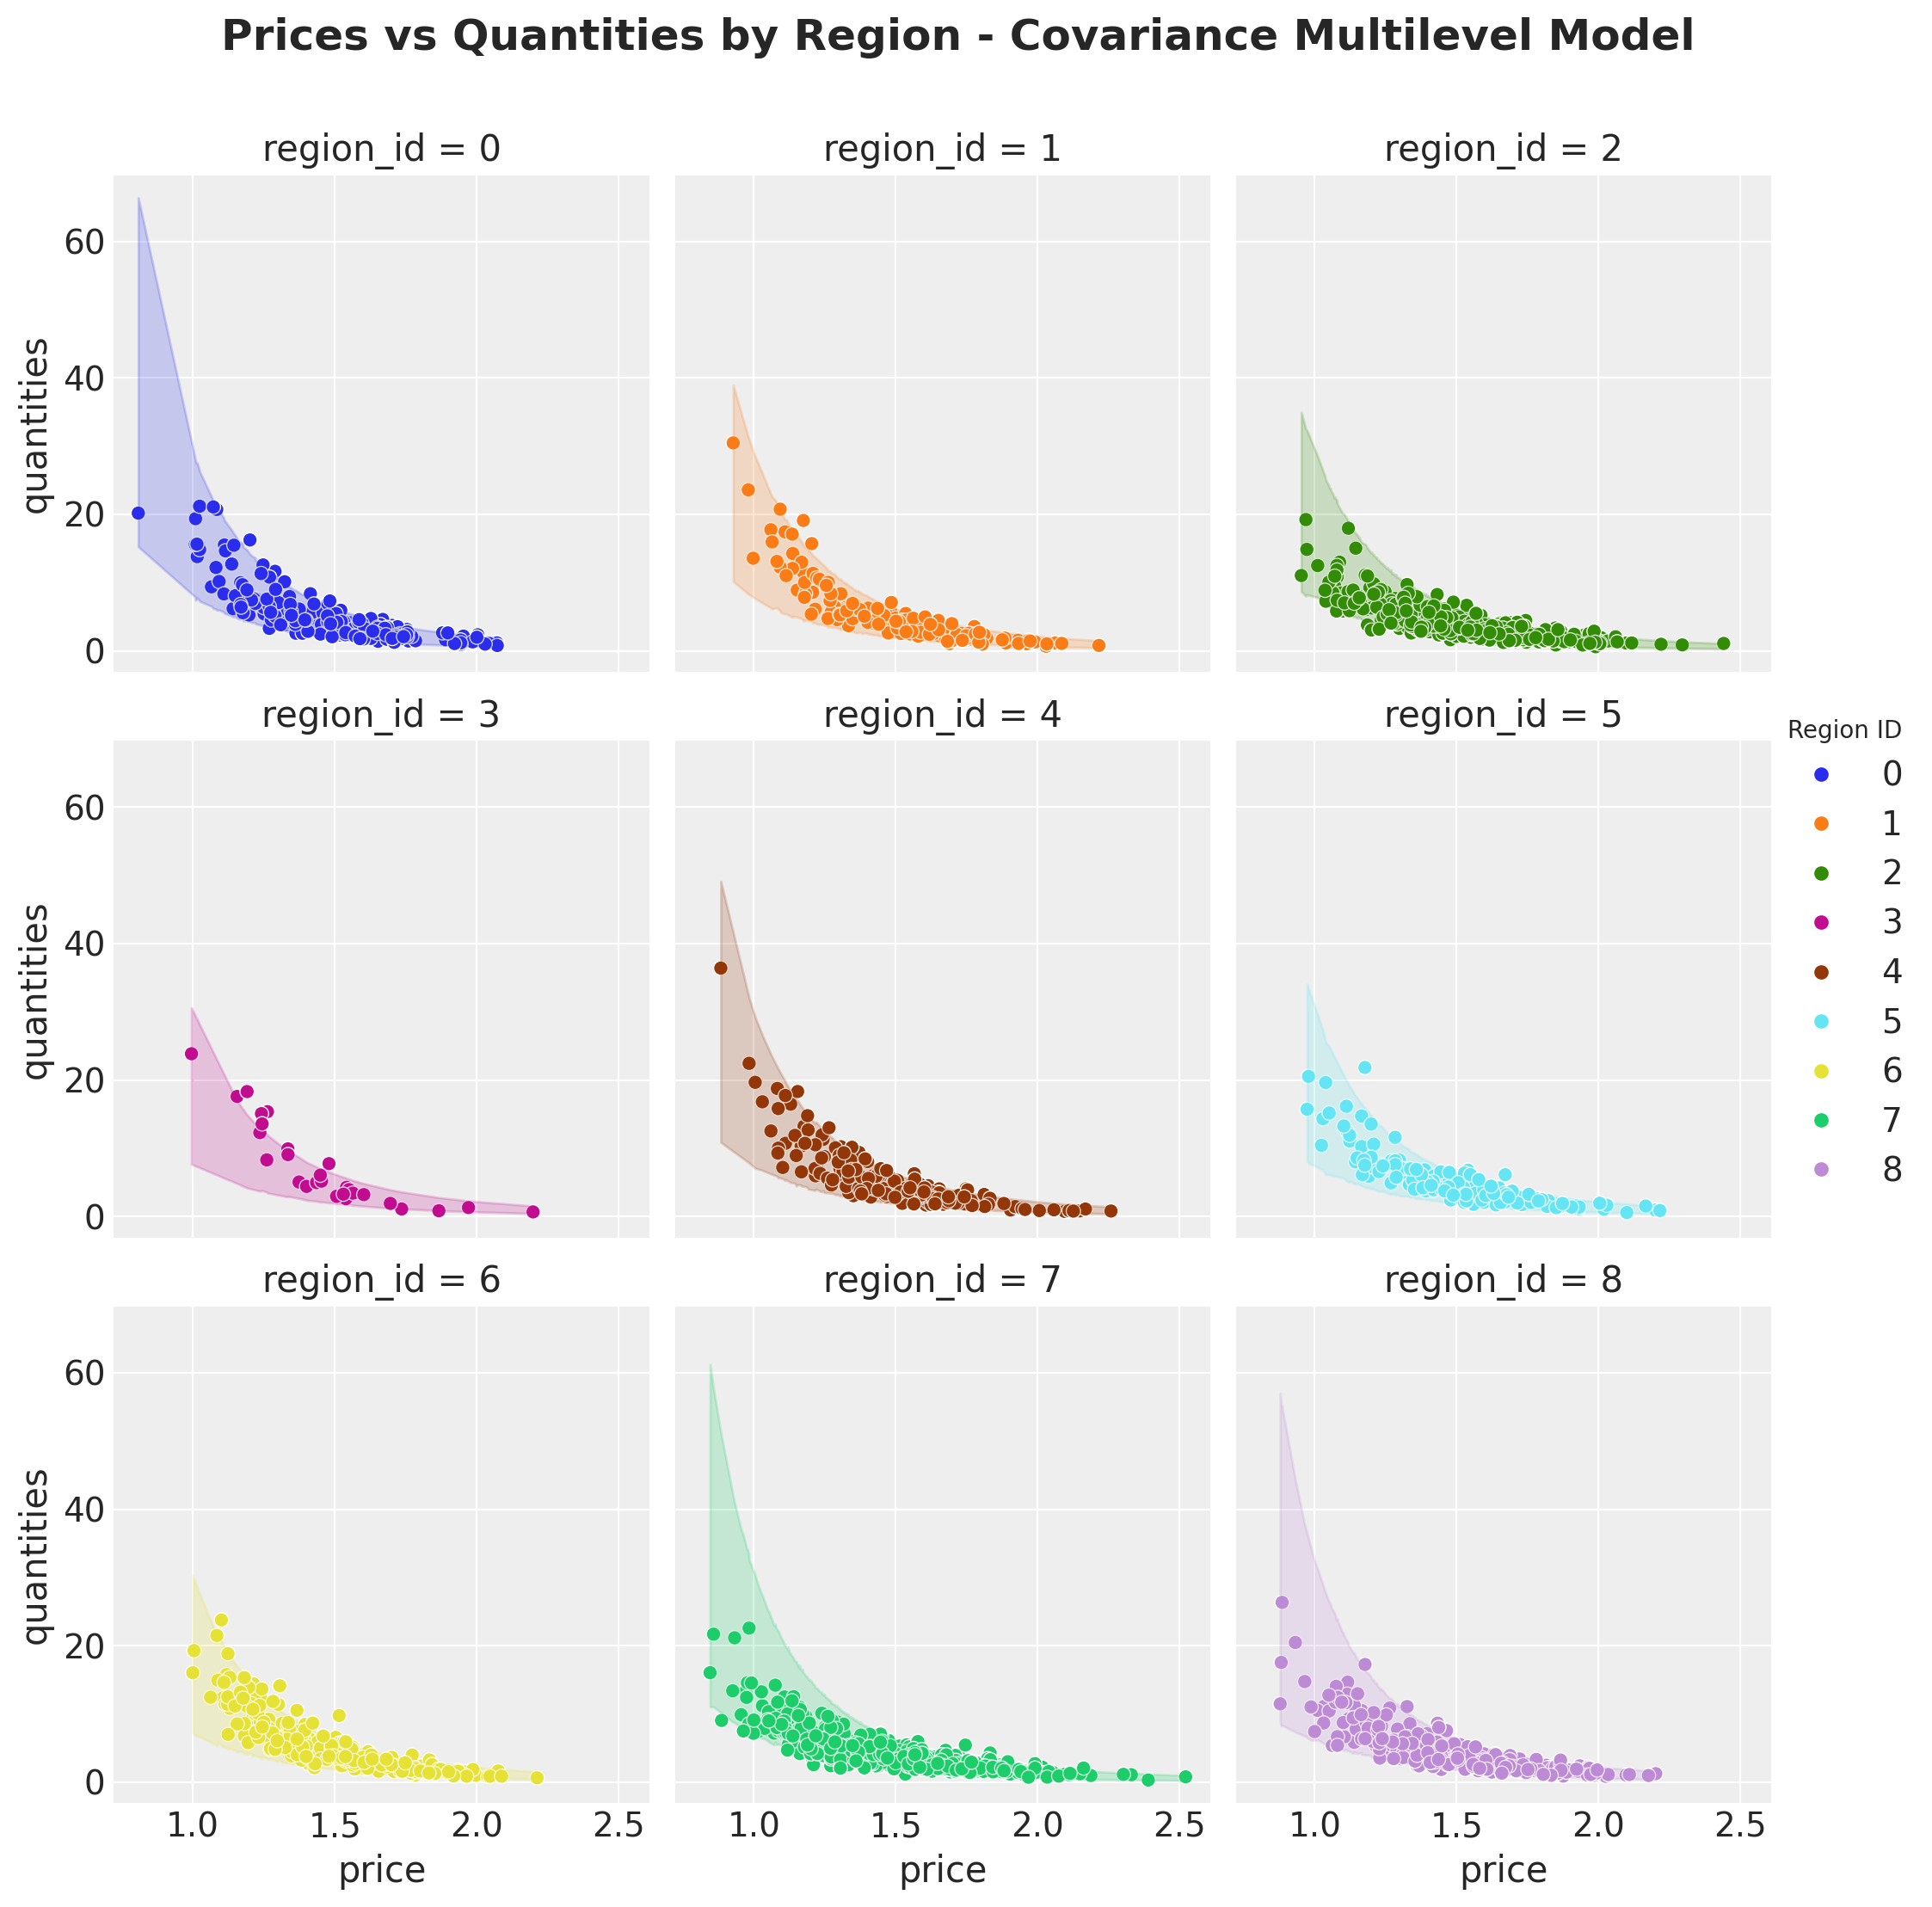

In [21]:
exp_likelihood_hdi = az.hdi(
    ary=np.exp(posterior_predictive_cov["posterior_predictive"]["likelihood"])
)["likelihood"]

g = sns.relplot(
    data=market_df.assign(region_id=lambda x: x["region_id"].astype(str)),
    x="price",
    y="quantities",
    kind="scatter",
    col="region_id",
    col_wrap=3,
    hue="region_id",
    height=3.5,
    aspect=1,
    facet_kws={"sharex": True, "sharey": True},
)

axes = g.axes.flatten()

for i, region_to_plot in enumerate(region):
    ax = axes[i]

    price_region = price[region_idx == region_to_plot]
    price_region_argsort = np.argsort(price_region)

    ax.fill_between(
        x=price_region[price_region_argsort],
        y1=exp_likelihood_hdi[region_idx == region_to_plot][price_region_argsort, 0],
        y2=exp_likelihood_hdi[region_idx == region_to_plot][price_region_argsort, 1],
        color=f"C{i}",
        alpha=0.2,
    )

legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle(
    "Prices vs Quantities by Region - Covariance Multilevel Model",
    y=1.05,
    fontsize=18,
    fontweight="bold",
)

The posterior predictive distribution does for the data of the new region but the $94\%$ interval is much wider thatn for the original model in the previous notebook where we included all regions.

One can of course build hierarchies not only on the mean of the likelihood but also in the standard deviation. This is left as an exercise for the reader.